In [2]:
import pandas as pd
import matplotlib.pyplot as plt

social = pd.read_csv("Aggregated_reddit_twitter.csv")
social = social.rename(columns={"date": "timestamp"})
social["timestamp"] = pd.to_datetime(social["timestamp"])



/tmp/ipykernel_321359/353302006.py:4: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  social = pd.read_csv("Aggregated_reddit_twitter.csv")


In [3]:
social = social[social.content != "u/circular360"]
social = social[
    social.content != "Why force the other player to stay around? Just give the winning player the option to continue the game with a perma passing AI controlling the surrendering player."]

In [4]:
crypto = pd.read_csv("transformed_crypto.csv")
crypto["timestamp"] = pd.to_datetime(crypto["timestamp"]).dt.tz_localize(None)


In [5]:
# crypto.dtypes, social.dtypes

In [6]:
social = social.sort_values(by="timestamp")

In [7]:
# social.dtypes
sr = social.resample("T", on="timestamp").size()
freq = sr.reset_index()

freq = freq.rename(columns={0: "n_comments"})

In [12]:
mg = pd.merge(crypto, freq, on="timestamp", how="outer")

In [13]:
# freq.idxmax()

In [18]:
# freq.iloc[52981]
crypto.describe()

,Unnamed: 0,timestamp,XRP-PERP,SOL-PERP,ETH-PERP,DOGE-PERP,BTC-PERP,APE-PERP
count,875267.000000,875267,8.751370e+05,8.751400e+05,8.751290e+05,8.751240e+05,8.751220e+05,2.410700e+05
mean,437633.000000,2021-11-01 00:46:55.206604544,-9.561190e-17,-2.348719e-16,-3.346447e-16,4.073959e-16,1.787557e-16,5.281838e-17
min,0.000000,2021-01-01 00:01:00,-1.594297e+00,-1.194694e+00,-1.953565e+00,-1.453949e+00,-2.030118e+00,-1.279958e+00
25%,218816.500000,2021-06-02 01:58:30,-9.192413e-01,-7.215385e-01,-8.291290e-01,-8.725178e-01,-6.739563e-01,-7.889873e-01
50%,437633.000000,2021-11-01 01:04:00,-1.691518e-02,-5.248144e-01,-3.172077e-02,-1.936364e-01,-5.533288e-03,-3.825940e-01
75%,656449.500000,2022-04-02 00:21:30,6.874922e-01,5.880011e-01,6.975142e-01,6.609572e-01,6.500687e-01,7.625053e-01
max,875266.000000,2022-09-01 00:00:00,3.675641e+00,2.837246e+00,2.381488e+00,5.181731e+00,2.314610e+00,4.510921e+00
std,252667.963369,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
social.describe()

,timestamp,likes,replies,other_scores
count,1598505,1.598505e+06,1.598505e+06,0.0
mean,2022-12-13 06:16:50.397362944,6.699567e+00,9.253415e-01,NaN
min,2022-11-03 19:32:10,-2.086000e+03,0.000000e+00,NaN
25%,2022-11-21 11:11:08,1.000000e+00,0.000000e+00,NaN
50%,2022-12-12 10:53:37,1.000000e+00,0.000000e+00,NaN
75%,2023-01-03 22:57:18,3.000000e+00,0.000000e+00,NaN
max,2023-02-04 06:25:59,4.466200e+04,9.593000e+03,NaN
std,NaN,1.011696e+02,2.110393e+01,NaN


In [16]:
# social.between_time('2022-11-09 13:58:00', "2022-11-09 14:00:00")
# social.loc[(social['timestamp'] > '2022-12-10 14:32:00') & (social['timestamp'] < "2022-12-10 14:34:00")]

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt



mg =  mg.loc[(mg['timestamp'] > '2021-12-1 00:00:00') & (mg['timestamp'] < "2021-12-25 23:59:59")]
mg.describe()

,Unnamed: 0,timestamp,XRP-PERP,SOL-PERP,ETH-PERP,DOGE-PERP,BTC-PERP,APE-PERP,n_comments
count,0.0,35999,0.0,0.0,0.0,0.0,0.0,0.0,35999.000000
mean,NaN,2022-12-13 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12.446179
min,NaN,2022-12-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2022-12-07 06:00:30,NaN,NaN,NaN,NaN,NaN,NaN,8.000000
50%,NaN,2022-12-13 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12.000000
75%,NaN,2022-12-19 17:59:30,NaN,NaN,NaN,NaN,NaN,NaN,16.000000
max,NaN,2022-12-25 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,152.000000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.334004


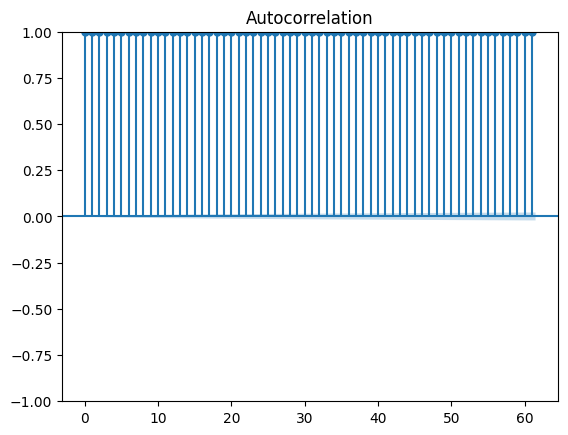

/home/dario/PycharmProjects/BAINSACryptocurrencies/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


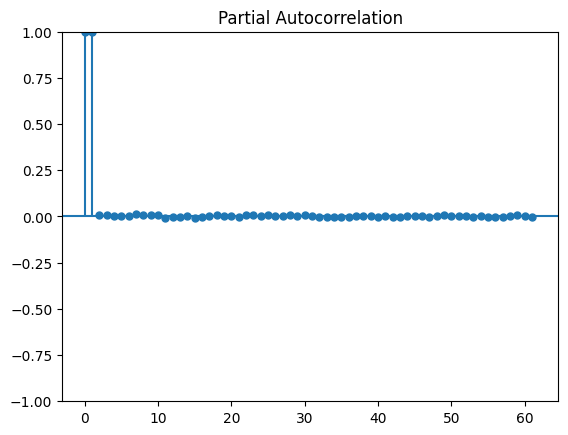

/home/dario/PycharmProjects/BAINSACryptocurrencies/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dario/PycharmProjects/BAINSACryptocurrencies/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81107D+00    |proj g|=  8.15994D+00

At iterate    5    f= -4.11743D+00    |proj g|=  7.23715D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     19      1     0     0   2.960D-05  -4.117D+00
  F =  -4.1174480711967743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:




# Assuming you have a pandas DataFrame named "mg" with a timestamp column named "timestamp"
# Make sure the timestamp column is of datetime type
mg['timestamp'] = pd.to_datetime(mg['timestamp'])

# Set the timestamp column as the index
mg.set_index('timestamp', inplace=True)

# Resample the data if needed (e.g., to daily frequency)
# mg = mg.resample('D').mean()

# Add day of the week as an external variable
mg['day_of_week'] = mg.index.dayofweek

# Fill any missing values
mg.fillna(method='ffill', inplace=True)

# Plot the autocorrelation and partial autocorrelation functions
# plot_acf(mg['BTC-PERP'])
# plt.show()
#
# plot_pacf(mg['BTC-PERP'])
# plt.show()

# Fit the ARIMA model (you can change the order and seasonal_order based on the plots above)
model = SARIMAX(mg['BTC-PERP'], exog=mg['day_of_week'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend='c')
results = model.fit()

# Print the model summary
print(results.summary())

# Make predictions
predictions = results.get_prediction(start=pd.to_datetime('2023-01-01'), end=pd.to_datetime('2023-04-01'), exog=mg.loc['2023-01-01':'2023-04-01', 'day_of_week'])

# Plot the predictions
plt.plot(mg['BTC-PERP'], label='Observed')
plt.plot(predictions.predicted_mean, label='Predicted', linestyle='--')
plt.legend()
plt.show()